In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsRegressor
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import optuna

In [ ]:
# Define the objective function
def knn_objective(trial):
    
    params = {
        'n_neighbors': trial.suggest_int('n_neighbors', 1, 30),
        'weights': trial.suggest_categorical('weights', ['uniform', 'distance']),
        'algorithm': trial.suggest_categorical('algorithm', ['ball_tree', 'kd_tree', 'brute']),
        'p': trial.suggest_int('p', 1, 2)  # 1 = manhattan_distance, 2 = euclidean_distance
    }
    
    model = KNeighborsRegressor(**params)
    model.fit(X_train, y_train)
    
    preds = model.predict(X_test)
    rmse = mean_squared_error(y_test, preds, squared=False)
    
    return rmse

In [2]:
# Load dataset
df = pd.read_csv('test-data/2015_to_2022_dataset.csv')

In [3]:
# Replace missing values with NaN
df.replace("", np.nan, inplace=True)

In [4]:
df.isnull().sum()

Code                         0
Locale                       0
Date                         0
Temperature                  7
Precipitation            63134
Wind_Speed                  55
Wind_Direction              68
Humidity                    35
Vapor_Pressure               7
Dew_Point_Temperature       10
Spot_Atm_Pressure           21
Sea_Level_Pressure          17
Daylight_Time            32027
Insolation               31852
Snowfall_Amount          68051
Clouds_Amount             7111
Ground_Temperature          67
SO2                       1486
CO                        2672
NO2                       2074
PM10                      1436
PM2_5                     1330
O3                        1397
dtype: int64

In [5]:
df['Date'] = pd.to_datetime(df['Date'])
df['Date'] = df['Date'].dt.strftime('%y%m%d%H')
df['Date'] = df['Date'].astype(int)

df['Year'] = df['Date'].apply(lambda x: 2000 + int(str(x)[:2]))  # Adding 2000 to get the full year, e.g., 2015
df['Month'] = df['Date'].apply(lambda x: int(str(x)[2:4]))
df['Day'] = df['Date'].apply(lambda x: int(str(x)[4:6]))
df['Hour'] = df['Date'].apply(lambda x: int(str(x)[6:]))

In [6]:
# Define the columns to be imputed with the median
median_columns = [
    'Temperature', 'Wind_Speed', 'Wind_Direction', 'Humidity',
    'Vapor_Pressure', 'Dew_Point_Temperature', 'Spot_Atm_Pressure',
    'Sea_Level_Pressure', 'SO2', 'CO', 'NO2', 'PM10', 'PM2_5', 'O3',
    'Ground_Temperature'
]

# Define the columns to be imputed with zero
zeroing_columns = [
    'Precipitation', 'Daylight_Time', 'Insolation',
    'Snowfall_Amount', 'Clouds_Amount'
]

# Create imputer for median
imputer_median = SimpleImputer(strategy='median')

# Apply the imputer to the columns that require the median
df[median_columns] = imputer_median.fit_transform(df[median_columns])

# Fill the NaN values with zero for the columns that require zeroing
df[zeroing_columns] = df[zeroing_columns].fillna(0)

# Check if there are any remaining NaN values
print(df.isnull().sum())

Code                     0
Locale                   0
Date                     0
Temperature              0
Precipitation            0
Wind_Speed               0
Wind_Direction           0
Humidity                 0
Vapor_Pressure           0
Dew_Point_Temperature    0
Spot_Atm_Pressure        0
Sea_Level_Pressure       0
Daylight_Time            0
Insolation               0
Snowfall_Amount          0
Clouds_Amount            0
Ground_Temperature       0
SO2                      0
CO                       0
NO2                      0
PM10                     0
PM2_5                    0
O3                       0
Year                     0
Month                    0
Day                      0
Hour                     0
dtype: int64


In [7]:
df = df.drop(columns = ['Date','Code', 'Locale'])

In [ ]:
df = df.drop(columns = ['SO2', 'CO','PM10','PM2_5'])

In [8]:
# Specify the target variable
y = df['O3']

In [10]:
# Specify the feature variables
X = df.drop(['O3'], axis=1)

In [12]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Standardize the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [ ]:
# Define the hyperparameters grid
param_grid = {'n_neighbors': list(range(1, 31)), 'weights': ['uniform', 'distance']}

# Initialize KNN Regressor
knn = KNeighborsRegressor()


# Initialize GridSearchCV
grid_search = GridSearchCV(knn, param_grid, cv=5, n_jobs=-1, scoring='neg_mean_squared_error')

# Fit GridSearchCV
grid_search.fit(X_train, y_train)

# Print the best parameters
print("Best parameters: ", grid_search.best_params_)

# Initialize KNN Regressor with the best parameters
model = grid_search.best_estimator_

# Fit the model
model.fit(X_train, y_train)

In [ ]:
# Initialize Optuna study
study = optuna.create_study(direction='minimize')
study.optimize(knn_objective, n_trials=100, n_jobs=-1)

print("Best trial:")
trial = study.best_trial
print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))
    
# Best parameters from Optuna
best_params = study.best_params

# Train final KNN model with best hyperparameters
final_knn_model = KNeighborsRegressor(**best_params)
final_knn_model.fit(X_train, y_train)

In [25]:
# Make predictions
predictions = model.predict(X_test)

In [27]:
# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test, predictions))
print("RMSE: %f" % (rmse))

RMSE: 0.008475


In [28]:
# Calculate MAE
mae = mean_absolute_error(y_test, predictions)
print("MAE: %f" % (mae))

MAE: 0.005713


In [29]:
# Calculate R2 Score
r2 = r2_score(y_test, predictions)
print("R2 Score: %f" % (r2))

R2 Score: 0.805039


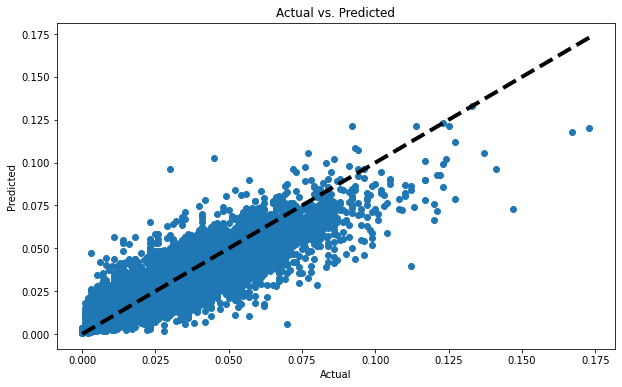

In [30]:
# Plot Actual vs. Predicted
plt.figure(figsize=(10,6))
plt.scatter(y_test, predictions)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs. Predicted')
plt.show()

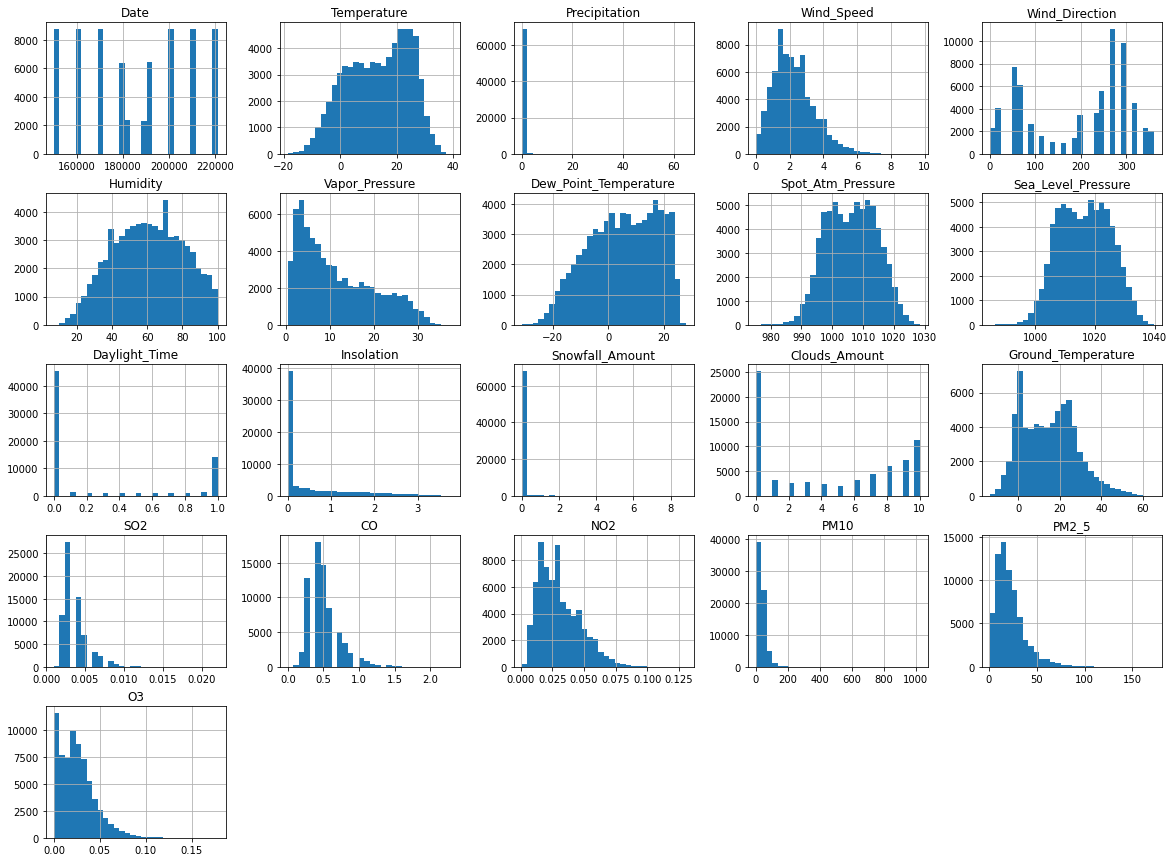

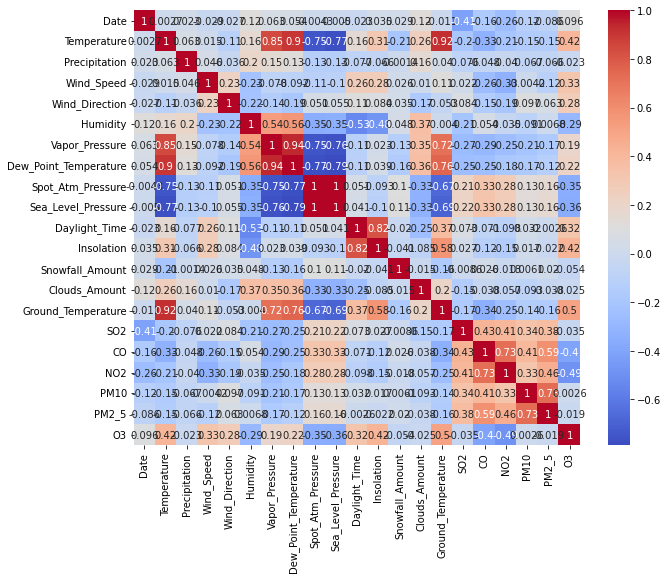

ValueError: num must be 1 <= num <= 15, not 16

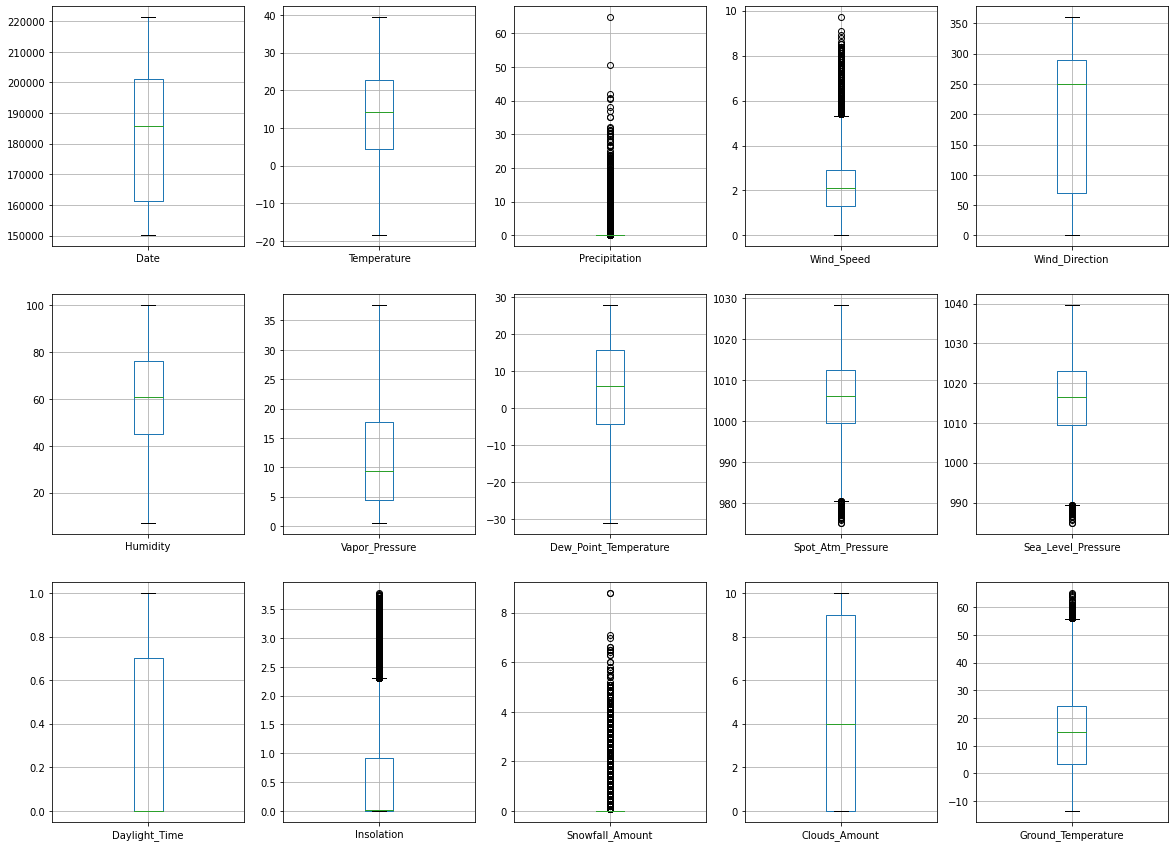

In [31]:
# Histograms for each variable in your dataset
df.hist(bins=30, figsize=(20,15))
plt.show()

# Heatmap of Correlations
plt.figure(figsize=(10,8))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
plt.show()

# Box plots for each variable
plt.figure(figsize=(20, 15))
for i, column in enumerate(df.columns, 1):
    plt.subplot(3, 5, i)
    df.boxplot(column)
plt.show()